## Импорты

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error,r2_score

## Найти данные, на которых интересно будет решать задачу регрессии (больше 1000 строк, больше 5 признаков).

Стандартный датасет про калифорнию

In [2]:
df = pd.read_csv('housing.csv')

## Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (Data Cleaning).

In [83]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [84]:
df.isna().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,20640,20640,20640,20640,20640,20640,20640,20640,20640,20640
unique,1,1,1,1,2,1,1,1,1,1
top,False,False,False,False,False,False,False,False,False,False
freq,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640


В total_bedrooms у нас есть nan-ы. Проверим их.

In [85]:
df[df['total_bedrooms'].isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,NEAR BAY
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,NEAR BAY
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,NEAR BAY
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,NEAR BAY
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,NEAR OCEAN
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,NEAR OCEAN
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,<1H OCEAN
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,<1H OCEAN


В таблице у нас есть nan-ы. Будем ли мы их заполнять? Нет. Почему? К-во строк с nan-ами очень мало, потому нет смысла обращать внимание на эти поля.

## Выполнить разведочный анализ (EDA), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи регрессии.

In [3]:
df = df[df['total_bedrooms'].isna() == False]

In [122]:
df_without_ocean = df.drop(columns=['ocean_proximity'])

<Axes: >

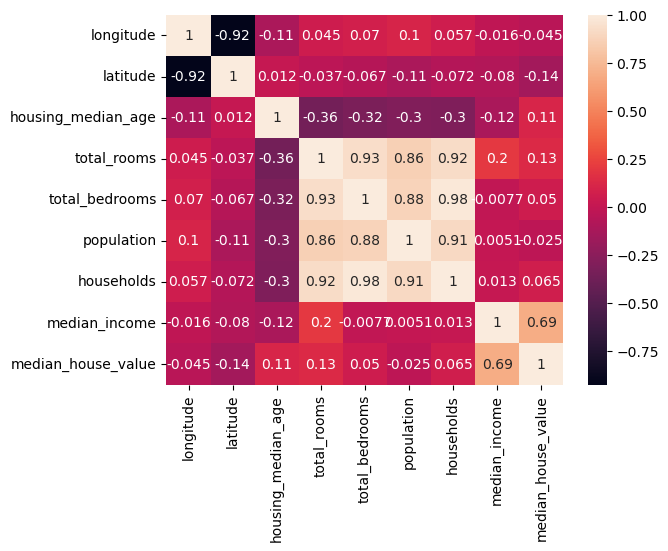

In [123]:
sns.heatmap(df_without_ocean.corr(),annot=True)

Очевидно, надо дропать колонки, чтобы избежать мультиколлинеарности. Сделаем это в будущем.

Следовательно, у нас вырисовывается 2 пайплайна, без дропа и с ним.

!!!Даже без графиков!!! 
Очевидно, что у нас сильный разброс в мерах данных. Например, возраст здания и его цена, следовательно, нам нужны скейлеры. Используем стандарт-скейлер. А также необходимо привести данные к одной мере

## При необходимости выполнить полезные преобразования данных (например, трансформировать категориальные признаки в количественные), убрать ненужные признаки, создать новые (Feature Engineering).

In [167]:
df[:1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


Приведем некоторые колонки к среднему + к одному "размаху"

In [169]:
df['total_rooms'] = df['total_rooms'] / df['households']
df['total_bedrooms'] = df['total_bedrooms'] / df['households']
df['population'] = df['population'] / df['households']
df['median_house_value'] = df['median_house_value']/100000

In [211]:
df_tree = df.copy() # для деревьев

In [170]:
df[:1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,6.984127,1.02381,2.555556,126.0,8.3252,4.526,NEAR BAY


## Модели

### Линейная регрессия

In [171]:
X = df.drop(columns=['longitude', 'total_bedrooms', 'population', 'households', 'median_house_value'])
y = df['median_house_value']

In [172]:
numeric_features = [col for col in X.columns if col != 'ocean_proximity']
categorical_features = ['ocean_proximity']

In [182]:
preprocessor_df = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [183]:
pipeline_df = Pipeline(steps=[
    ('preprocessor', preprocessor_df),
    ('regressor', ElasticNet())
])

In [184]:
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'regressor__fit_intercept': [True, False]
}

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
grid_search = GridSearchCV(pipeline_df, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

In [248]:
y_pred = best_model.predict(X_test)
mse_df = mean_squared_error(y_test, y_pred)
print(f"MSE на df: {mse_df:.2f}")
r2 = r2_score(y_test, y_pred)
print(f"Lin. Reg R^2: {r2:.4f}")

MSE на df: 0.55
Lin. Reg R^2: 0.5954


Отлично, мы применили оптимизацию и получили нормальный результат.

### А теперь модели-деревья.

In [212]:
df_tree[:1]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,6.984127,1.02381,2.555556,126.0,8.3252,4.526,NEAR BAY


In [213]:
X = df_tree.drop('median_house_value', axis=1)
y = df_tree['median_house_value']

In [214]:
numeric_features = [col for col in X.columns if col != 'ocean_proximity']
categorical_features = ['ocean_proximity'] if 'ocean_proximity' in X.columns else []

In [215]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [231]:
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1))
])
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42))
])

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [242]:
tree_pipeline.fit(X_train, y_train)
y_pred = tree_pipeline.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred)
print(f"DecisionTreeRegressor MSE: {mse_tree:.2f}")
r2_tree = r2_score(y_test, y_pred_tree)
print(f"DecisionTreeRegressor R^2: {r2_tree:.4f}")

DecisionTreeRegressor MSE: 0.50
DecisionTreeRegressor R^2: 0.7450


In [241]:
rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"RandomForestRegressor MSE: {rmse_rf:.2f}")
r2_tree = r2_score(y_test, y_pred_rf)
print(f"RandomForestRegressor R^2: {r2_tree:.4f}")

RandomForestRegressor MSE: 0.26
RandomForestRegressor R^2: 0.8102


In [243]:
gb_pipeline.fit(X_train, y_train)
y_pred_gb = gb_pipeline.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"GradientBoostingRegressor MSE: {mse_gb:.2f}")
r2_tree = r2_score(y_test, y_pred_gb)
print(f"GradientBoostingRegressor R^2: {r2_tree:.4f}")

GradientBoostingRegressor MSE: 0.26
GradientBoostingRegressor R^2: 0.8099


## Выводы (без доп заданий)

В целом, проведённое сравнение моделей показало, что линейная регрессия справляется с задачей на базовом уровне, объясняя около 60% вариации цен на жильё (MSE = 0.55, R2 = 0.5954). Однако её возможности ограничены, поскольку данные содержат сложные и нелинейные зависимости, которые линейная модель не способна уловить.

Дерево решений уже демонстрирует заметно лучшую точность, объясняя примерно 75% вариации (MSE = 0.50, R2 = 0.7450). Оно умеет учитывать нелинейности, но при этом склонно к переобучению и чувствительно к отдельным наблюдениям.

Наибольшую точность показали ансамблевые методы - случайный лес и градиентный бустинг (RandomForest: MSE = 0.26, R2 = 0.8102; GradientBoosting: MSE = 0.26, R2 = 0.8099). Они смогли объяснить более 80% вариации данных, одновременно снижая эффект переобучения за счёт усреднения нескольких деревьев или последовательного обучения слабых моделей. Разница между ними по точности минимальна, но случайный лес обучается быстрее, что делает его более удобным для практического применения.

Таким образом, для этой задачи оптимальным выбором будет использование ансамблевых моделей деревьев, а линейная регрессия может служить быстрым ориентиром или базовой моделью для оценки качества признаков.

## (Доп., +5 балла) Самостоятельно реализовать один из регрессионных методов, с возможностью настройки гиперпараметров. Повторить все пункты задания для собственной реализации.

In [271]:
class MyRidgeRegression:
    def __init__(self, alpha=1.0, lr=0.01, n_iter=1000):
        self.alpha = alpha 
        self.lr = lr     
        self.n_iter = n_iter 
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iter):
            y_pred = X.dot(self.w) + self.b
            dw = (1/n_samples) * (X.T.dot(y_pred - y) + self.alpha * self.w)
            db = (1/n_samples) * np.sum(y_pred - y)
            self.w -= self.lr * dw
            self.b -= self.lr * db
        return self

    def predict(self, X):
        return X.dot(self.w) + self.b

In [262]:
X = df.drop(columns=['longitude', 'total_bedrooms', 'population', 'households', 'median_house_value'])
y = df['median_house_value']

In [267]:
encoded_data = ohe.fit_transform(df[['ocean_proximity']])
X.drop(columns=['ocean_proximity'],inplace=True)
X = pd.concat([X,encoded_data],axis=1)

In [281]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
my_lr = MyRidgeRegression(lr=0.01, n_iter=500, alpha=0.1).fit(X_train, y_train)

In [285]:
y_pred_scaled = my_lr.predict(X_test)
y_pred_lr = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test.reshape(-1,1)).flatten()

In [286]:
mse_lr = mean_squared_error(y_test_orig, y_pred_lr)
r2_lr = r2_score(y_test_orig, y_pred_lr)

print(f"MyRidgeRegression MSE: {mse_lr:.2f}")
print(f"MyRidgeRegression R^2: {r2_lr:.4f}")

MyRidgeRegression MSE: 0.55
MyRidgeRegression R^2: 0.5956


## (Доп., +5 балла) Используя два разных фреймворка автоматического машинного обучения, получить две модели для решения задачи регрессии. Сравнить полученные модели с использованными Вами.

In [4]:
df['total_rooms'] = df['total_rooms'] / df['households']
df['total_bedrooms'] = df['total_bedrooms'] / df['households']
df['population'] = df['population'] / df['households']
df['median_house_value'] = df['median_house_value']/100000

In [5]:
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

In [6]:
ohe = OneHotEncoder(sparse_output=False) 
encoded_data = ohe.fit_transform(X[['ocean_proximity']])
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['ocean_proximity']))
X = X.drop(columns=['ocean_proximity']).reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)
X = pd.concat([X, encoded_df], axis=1)

## TPOT

In [7]:
from tpot import TPOTRegressor

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
tpot = TPOTRegressor(
    generations=3,
    population_size=3,
    max_time_mins=35,
    random_state=42,
    n_jobs=8
)

In [10]:
X_small = X_train[:3000]
y_small = y_train[:3000]
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X_small)

In [12]:
tpot.fit(X_scaled, y_small)

/home/mazer1x/miniconda3/envs/menv/lib/python3.10/site-packages/tpot/tpot_estimator/estimator.py:458: UserWarning: Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.
  warnings.warn("Both generations and max_time_mins are set. TPOT will terminate when the first condition is met.")
Generation: 100%|███████████████████████████████████████████| 3/3 [1:00:10<00:00, 1203.39s/it]


,search_space,<tpot.search_...x7de7ccfc2b90>
,scorers,['neg_mean_squared_error']
,scorers_weights,[1]
,cv,10
,other_objective_functions,[]
,other_objective_functions_weights,[]
,objective_function_names,None
,bigger_is_better,True
,categorical_features,None
,memory,None
,preprocessing,False


In [13]:
y_pred_tpot = tpot.predict(X_test)
mse_tpot = mean_squared_error(y_test, y_pred_tpot)
r2_tpot = r2_score(y_test, y_pred_tpot)

/home/mazer1x/miniconda3/envs/menv/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [14]:
print("TPOTRegressor:")
print(f"  MSE = {mse_tpot:.4f}")
print(f"  R2 = {r2_tpot:.4f}")

TPOTRegressor:
  MSE = 3.6496
  R2 = -1.6688


Слабые результаты, попробуем другие либы найти

## FLAML

In [15]:
from flaml import AutoML

In [18]:
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Надо переименовать колонки, потому что иначе xgboost не съест
X_train_clean.columns = [
    str(c).replace("[","_").replace("]","").replace("<","_").replace(">","_")
    for c in X_train_clean.columns
]
X_test_clean.columns = [
    str(c).replace("[","_").replace("]","").replace("<","_").replace(">","_")
    for c in X_test_clean.columns
]


In [24]:
automl = AutoML()
automl_settings = {
    "task": "regression",
    "time_budget": 30, 
    "metric": "r2"
}

In [25]:
automl.fit(X_train_clean, y_train, **automl_settings)

[flaml.automl.logger: 11-25 14:02:56] {1752} INFO - task = regression
[flaml.automl.logger: 11-25 14:02:56] {1763} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-25 14:02:56] {1862} INFO - Minimizing error metric: 1-r2
[flaml.automl.logger: 11-25 14:02:56] {1979} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 11-25 14:02:56] {2282} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 11-25 14:02:56] {2417} INFO - Estimated sufficient time budget=480s. Estimated necessary time budget=3s.
[flaml.automl.logger: 11-25 14:02:56] {2466} INFO -  at 0.1s,	estimator lgbm's best error=0.7134,	best estimator lgbm's best error=0.7134
[flaml.automl.logger: 11-25 14:02:56] {2282} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 11-25 14:02:56] {2466} INFO -  at 0.2s,	estimator lgbm's best error=0.7134,	best estimator lgbm's best error=0.7134
[flaml.automl.logger: 11-25 14:02:56] {228

In [26]:
y_pred = automl.predict(X_test_clean)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [27]:
print(f"MSE = {mse:.4f}")
print(f"R2 = {r2:.4f}")

MSE = 0.2318
R2 = 0.8305


## H2O

In [40]:
import h2o
from h2o.automl import H2OAutoML

In [41]:
h2o.init(max_mem_size="2G") 

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "21.0.6" 2025-01-21; OpenJDK Runtime Environment JBR-21.0.6+9-895.97-nomod (build 21.0.6+9-b895.97); OpenJDK 64-Bit Server VM JBR-21.0.6+9-895.97-nomod (build 21.0.6+9-b895.97, mixed mode, sharing)
  Starting server from /home/mazer1x/miniconda3/envs/menv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp5f3hv365
  JVM stdout: /tmp/tmp5f3hv365/h2o_mazer1x_started_from_python.out
  JVM stderr: /tmp/tmp5f3hv365/h2o_mazer1x_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Moscow
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.9
H2O_cluster_version_age:,21 hours and 41 minutes
H2O_cluster_name:,H2O_from_python_mazer1x_4w9o2c
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.978 Gb
H2O_cluster_total_cores:,15
H2O_cluster_allowed_cores:,15
H2O_cluster_status:,"locked, healthy"


In [46]:
train_h2o = h2o.H2OFrame(pd.concat([X_train_clean, y_train], axis=1))
test_h2o = h2o.H2OFrame(pd.concat([X_test_clean, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
y_col = 'median_house_value'
x_cols = [c for c in train_h2o.columns if c != y_col]

In [48]:
aml = H2OAutoML(max_runtime_secs=300, seed=42)
aml.train(x=x_cols, y=y_col, training_frame=train_h2o)

AutoML progress: |
14:11:50.47: XGBoost_1_AutoML_2_20251125_141149 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_2_20251125_141149_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


████
14:11:57.41: XGBoost_2_AutoML_2_20251125_141149 [XGBoost def_1] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_2_AutoML_2_20251125_141149_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


███████
14:12:32.101: XGBoost_3_AutoML_2_20251125_141149 [XGBoost def_3] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_3_AutoML_2_20251125_141149_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.


█

key,value
Stacking strategy,cross_validation
Number of base models (used / total),6/49
# GBM base models (used / total),6/39
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/7
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


## Общие выводы // Сравнить полученные модели с использованными Вами.

| Модель                     | MSE     | R2       | Комментарий |
|-----------------------------|---------|----------|-------------|
| **Линейная регрессия**      | 0.55    | 0.5954   | Базовая модель, объясняет ~60% вариации, не улавливает сложные нелинейности |
| **MyRidgeRegression**       | 0.55    | 0.5956   | Регуляризация улучшает стабильность, аналогично обычной линейной регрессии |
| **Дерево решений**          | 0.50    | 0.7450   | Учитывает нелинейности, но склонно к переобучению и чувствительно к выбросам |
| **RandomForest**            | 0.26    | 0.8102   | Ансамблевый метод, уменьшает переобучение, быстрый в обучении, точность >80% |
| **GradientBoosting**        | 0.26    | 0.8099   | Ансамблевый бустинг, высокая точность, чуть медленнее обучения |
| **TPOT**                    | 3.6496  | -1.6688  | Без масштабирования и обработки OHE — очень плохие результаты |
| **FLAML**                   | 0.2318  | 0.8305   | Лучший результат, автоматический подбор модели и гиперпараметров, точность ~83% |
| **H2O AutoML**              | 0.39    | 0.71     | Хорошие результаты, но чуть уступает FLAML |


Сравнение моделей показывает, как различается их точность на нашей задаче прогнозирования:

Линейная регрессия и MyRidgeRegression демонстрируют базовый уровень предсказаний с MSE около 0.55 и R2 около 0.595, объясняя примерно 60% вариации данных. Они подходят для быстрого ориентирования и базовой оценки качества признаков, но не улавливают сложные нелинейные зависимости.

Дерево решений показывает заметный рост точности: MSE = 0.50, R2 = 0.745. Модель умеет учитывать нелинейности, но склонна к переобучению и чувствительна к выбросам.

Ансамблевые методы, такие как RandomForest и GradientBoosting, достигают ещё более высокой точности: MSE = 0.26, R2 ~ 0.81, объясняя более 80% вариации данных. RandomForest обучается быстрее, что делает его удобным для практического применения, в то время как GradientBoosting достигает схожей точности, но обучение происходит чуть медленнее.

Автоматические методы AutoML показали интересные результаты: TPOT в текущем виде справился плохо (MSE = 3.6496, R2 = -1.6688), из-за сложности обучения. FLAML показал лучший результат среди всех моделей (MSE = 0.2318, R2 = 0.8305), благодаря автоматическому подбору модели и гиперпараметров. H2O AutoML также показал хорошие результаты (MSE = 0.39, R2 = 0.71), но уступил FLAML и потребовал удаления пропусков в целевой переменной.

В целом, для данной задачи оптимальным выбором являются ансамблевые методы и современные AutoML решения, а линейные модели могут служить лишь базовой отправной точкой.
